Here we train and test a binary classifier on Rap1 TF motif data. We first import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nn import io, nn, preprocess
from sklearn.model_selection import train_test_split

Here we add commands to autoreload the imported packages, including changes to nn.

In [2]:
%load_ext autoreload
%autoreload 2

Here we load the sequence data from the positive and negative examples of the Rap1 TF motifs.

In [3]:
pos = io.read_text_file("data/rap1-lieb-positives.txt")
neg = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

We must now trim our negative examples, which are longer sequences than our positive examples, to be the same length as input for our neural network.

In [4]:
trimmed_neg = []
for s in neg:
    trimmed_neg.append(s[0:len(max(pos, key=len))])

We now upsample our positive class to be the same size as our negative class dataset, then one-hot-encode our sampled sequences.

In [5]:
labels = [1] * len(pos) + [0] * len(trimmed_neg)
sampled_seqs, sampled_labels = preprocess.sample_seqs(pos + trimmed_neg, labels)
encoded_seqs = preprocess.one_hot_encode_seqs(sampled_seqs)

In [ ]:
We can then do a train/test split of the sequence data 0.8/0.2.

In [6]:
encoded_seqs = np.array(encoded_seqs)
sampled_labels = np.array(sampled_labels)
X_train, X_test, y_train, y_test = train_test_split(encoded_seqs, sampled_labels, test_size=0.2, random_state=1)
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)
print("ytrain shape: ", y_train.shape)
print("ytest shape: ", y_test.shape)

train shape:  (5060, 68)
test shape:  (1266, 68)
ytrain shape:  (5060,)
ytest shape:  (1266,)


Now we can train a 68x16x68 instance of our neural network with a grid search of hyperparameters (dimensions adjusted based on the size of the input data). We vary the learning rate, batch size, and epoch count for training. We use BCE instead of MSE as the data labels are binary. We also used the relu activation function, as this performed better than the relu function.

In [17]:
nn_arch = [{'input_dim': 68, 'output_dim': 16, 'activation': 'relu'}, {'input_dim': 16, 'output_dim': 68, 'activation': 'relu'}]
lrs = np.logspace(-1.0, -2.0, num=2)
seed = 42
batch_sizes = np.array([50, 100])
epochss = np.array([50, 100])
loss_function = 'bce'
hyperparams = {}

for lr in lrs:
    for batch_size in batch_sizes:
        for epochs in epochss:
            print("training with the following hyperparameters: ", "lr=" + str(lr) + " " + "batch=" + str(batch_size) + " " + "epochs=" + str(epochs))
            classifier = nn.NeuralNetwork(nn_arch=nn_arch, lr=lr, seed=seed, batch_size=batch_size, epochs=epochs, loss_function=loss_function)
            _, loss_test = classifier.fit(X_train, y_train, X_test, y_test)
            hyperparams[('lr=' + str(lr), 'batch size=' + str(batch_size), 'epochs=' + str(epochs))] = loss_test[-1]

print("optimal hyperparameters for training are: ", min(hyperparams, key=hyperparams.get))


training with the following hyperparameters:  lr=0.1 batch=50 epochs=50
training with the following hyperparameters:  lr=0.1 batch=50 epochs=100
training with the following hyperparameters:  lr=0.1 batch=100 epochs=50
training with the following hyperparameters:  lr=0.1 batch=100 epochs=100
training with the following hyperparameters:  lr=0.01 batch=50 epochs=50
training with the following hyperparameters:  lr=0.01 batch=50 epochs=100
training with the following hyperparameters:  lr=0.01 batch=100 epochs=50
training with the following hyperparameters:  lr=0.01 batch=100 epochs=100
optimal hyperparameters for training are:  ('lr=0.1', 'batch size=50', 'epochs=50')


We find that the optimal hyperparameters for training are: lr=0.1, batch size=50, and epoch count=50. We can now train an instance of our neural network with these hyperparameters.

In [18]:
nn_arch = [{'input_dim': 68, 'output_dim': 16, 'activation': 'relu'}, {'input_dim': 16, 'output_dim': 68, 'activation': 'relu'}]
trained_classifier = nn.NeuralNetwork(nn_arch=nn_arch, lr=0.1, seed=42, batch_size=50, epochs=50, loss_function='mse')
train_test, loss_test = trained_classifier.fit(X_train, y_train, X_test, y_test)

Now we can plot the training and test loss from our trained neural network. We find that the training loss reaches a steady-state after <5 epochs, and the validation loss fluctuates from 7 to 10.5 over 50 epochs. It appears that the trained neural network still has less than optimal performance on the validation set, as the validation accuracy does not reach a steady state. This suggests that the model may be overfitting on the training data even with optimal hyperparameters, and perhaps regularization is needed (cross-validation). 

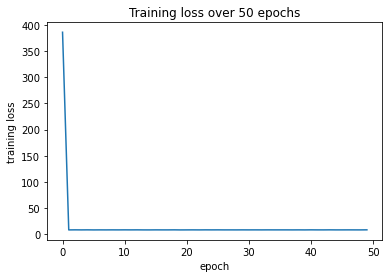

In [19]:
plt.figure()
plt.plot(train_test)
plt.title('Training loss over 50 epochs')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

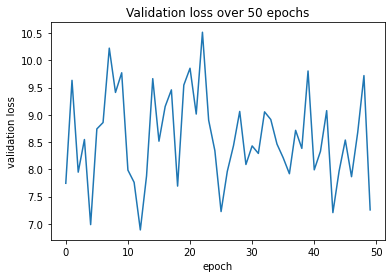

In [21]:
plt.figure()
plt.plot(loss_test)
plt.title('Validation loss over 50 epochs')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.show()

We can now calculate the average reconstruction error on the predictions from the model on the test set.

In [22]:
pred = trained_classifier.predict(X_test)
reconstruction_error = trained_classifier._mean_squared_error(pred, X_test)
print("average reconstruction error on validation set: ", reconstruction_error)

average reconstruction error on validation set:  7.193156319115972
